## Solar Panel Fault Identification 
### Task Model
Applied Machine Learning Project <br>

Solar Panel Fault Detection using CNN

**Task description and objectives**
- The aim of this project is to create a Machine Learning Model that accurately predicts and shows what type of defect a solar panel has, based on pictures of it.
- It will be a supervised learning model. 
- Supervised: Predict type or presence of defect (classification) based on image data.

### Data fetching and libraries

In [1]:
# Local changes needed for better visualisation of outputs 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # hides INFO and WARNING logs|

from IPython.display import HTML

HTML('''
<style>
/* for JupyterLab: limit each output pane to 400px tall and add a scrollbar */
.jp-OutputArea-child {
  max-height: 400px;
  overflow-y: auto;
}

/* for classic Jupyter: same idea */
.output_scroll {
  max-height: 400px;
  overflow-y: auto;
}
</style>
''')

In [2]:
# Libraries used throughout this script
import opendatasets as od
import os

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from pathlib import Path
from sklearn.model_selection import train_test_split
import shutil

E0000 00:00:1747940836.515582  125789 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747940836.566956  125789 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747940836.958401  125789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747940836.958452  125789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747940836.958455  125789 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747940836.958457  125789 computation_placer.cc:177] computation placer already registered. Please check linka

In [3]:
# GPU configuration (run in a notebook cell)
print("Built with CUDA:", tf.test.is_built_with_cuda())

build_info = tf.sysconfig.get_build_info()
print("CUDA version (build):", build_info.get("cuda_version"))
print("cuDNN version (build):", build_info.get("cudnn_version"))

gpus = tf.config.list_physical_devices("GPU")
print("GPUs visible to TF:", gpus)

Built with CUDA: True
CUDA version (build): 12.5.1
cuDNN version (build): 9
GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
od.download('https://www.kaggle.com/datasets/pythonafroz/solar-panel-images') # use force=True for forcing the download
data_dir = './solar-panel-images/Faulty_solar_panel'

Skipping, found downloaded files in "./solar-panel-images" (use force=True to force download)


### Data preprocessing

In [ ]:
# 1) Data parameters
img_size = (244, 244)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

# Point at your (possibly modified) images folder
data_root = Path(data_dir)

# Rebuild the list of all image paths *after* you deleted the bad ones
all_paths  = sorted(data_root.rglob("*.jpg"))
all_labels = [p.parent.name for p in all_paths]

class_names = sorted([p.name for p in data_root.iterdir() if p.is_dir()])
print("Classes:", class_names)

# 2. Train+Val vs. Test (e.g. 80/20)
paths_trainval, paths_test, labels_trainval, labels_test = train_test_split(
    all_paths, all_labels,
    test_size=0.20,
    stratify=all_labels,
    random_state=123
)

# 3. Train vs. Val within the 80%
paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_trainval, labels_trainval,
    test_size=0.20,  # 20% of 80% = 16% overall
    stratify=labels_trainval,
    random_state=123
)

# 4. Utility to build a tf.data.Dataset from (paths, labels)
def make_ds(paths, labels):
    # map filenames → (image_tensor, label_int)
    path_ds  = tf.data.Dataset.from_tensor_slices([str(p) for p in paths])
    label_to_index = {name:i for i,name in enumerate(class_names)}
    label_ds = tf.data.Dataset.from_tensor_slices([label_to_index[l] for l in labels])
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
    return ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
             .batch(batch_size) \
             .prefetch(AUTOTUNE)

def make_ds_test(paths, labels):
    # map filenames → (image_tensor, label_int)
    path_ds  = tf.data.Dataset.from_tensor_slices([str(p) for p in paths])
    label_to_index = {name:i for i,name in enumerate(class_names)}
    label_ds = tf.data.Dataset.from_tensor_slices([label_to_index[l] for l in labels])
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, label
    return ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
             .batch(batch_size) \
             .prefetch(AUTOTUNE)

# Filter out any paths that no longer exist on disk
paths_train  = [p for p in paths_train  if Path(p).exists()]
paths_val    = [p for p in paths_val    if Path(p).exists()]
paths_test   = [p for p in paths_test   if Path(p).exists()]

# Rebuild labels lists the same way
labels_train = [labels_train[i] for i,p in enumerate(paths_train) if Path(p).exists()]
labels_val   = [labels_val[i]   for i,p in enumerate(paths_val)   if Path(p).exists()]
labels_test  = [labels_test[i]  for i,p in enumerate(paths_test)  if Path(p).exists()]

train_ds = make_ds(paths_train, labels_train)
val_ds   = make_ds(paths_val,   labels_val)
test_ds  = make_ds_test(paths_test,  labels_test)

# Number of batches
train_batches = tf.data.experimental.cardinality(train_ds).numpy()
val_batches   = tf.data.experimental.cardinality(val_ds).numpy()
test_batches  = tf.data.experimental.cardinality(test_ds).numpy()

print("Train samples (approx):", train_batches * batch_size)
print("Val   samples (approx):",   val_batches   * batch_size)
print("Test  samples (approx):",   test_batches  * batch_size)

Classes: ['Bird-drop', 'Clean', 'Dusty', 'Electrical-damage', 'Physical-Damage', 'Snow-Covered']
Train samples (approx): 512
Val   samples (approx): 128


### LeNet Model

In [16]:
# Model definition LeNet
# ----------------
# Build a simple CNN using Keras Sequential API. Adjust the number of filters,
# kernel sizes, and dense units as needed for your solar-panel defect task.
num_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),    # input layer
    layers.Conv2D(8, kernel_size=5, activation='relu'),  # conv block 1
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(16, kernel_size=5, activation='relu'), # conv block 2
    layers.MaxPooling2D(pool_size=2),
    layers.GlobalAveragePooling2D(),                     # global pooling
    layers.Dense(128, activation='relu'),                # fully connected
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)                            # logits output
])

model.summary()  # prints model architecture and parameter counts

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 240, 240, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 120, 120, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 116, 116, 16)   │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 58, 58, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,646 (57.21 KB)

 Trainable params: 14,646 (57.21 KB)

 Non-trainable params: 0 (0.00 B)

### AlexNet Model

In [17]:
# Model definition
# ----------------
# Build a simple CNN using Keras Sequential API. Adjust the number of filters,
# kernel sizes, and dense units as needed for your solar-panel defect task.
num_classes = len(class_names)

model_AlexNet = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),    # input layer
    layers.Conv2D(64, kernel_size=11, activation='relu'),  # conv block 1
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(128, kernel_size=5, activation='relu'),   # conv block 2
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=3),                     # global pooling
    layers.Flatten(),
    layers.Dense(512, activation='relu'),                # fully connected
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')      # logits output
])

model_AlexNet.summary()  # prints model architecture and parameter counts|

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 234, 234, 64)   │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,688,390 (25.51 MB)

 Trainable params: 6,688,390 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

### Alt model

In [7]:
num_classes = len(class_names)

model = models.Sequential([
    layers.Input((244,244,3)),
    layers.Conv2D(16,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32,3,activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes, activation='softmax'),
])

model.summary()  # prints model architecture and parameter counts

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 242, 242, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 121, 121, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 119, 119, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 59, 59, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,590 (29.65 KB)

 Trainable params: 7,590 (29.65 KB)

 Non-trainable params: 0 (0.00 B)

### Model training

In [ ]:
# Compile & train
# ----------------
# Configure the training process: optimizer, loss function, and metrics.
# Then fit the model on `train_ds`, validating on `val_ds`.
epochs = 100

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=64,
    epochs=epochs
)

Epoch 1/200


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 237ms/step - loss: 1.0315 - sparse_categorical_accuracy: 0.6185 - val_loss: 0.9338 - val_sparse_categorical_accuracy: 0.6172
Epoch 2/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.9659 - sparse_categorical_accuracy: 0.6418 - val_loss: 0.9300 - val_sparse_categorical_accuracy: 0.6094
Epoch 3/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.9669 - sparse_categorical_accuracy: 0.6611 - val_loss: 0.9144 - val_sparse_categorical_accuracy: 0.6172
Epoch 4/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.9613 - sparse_categorical_accuracy: 0.6732 - val_loss: 0.9097 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.9555 - sparse_categorical_accuracy: 0.6589 - val_loss: 0.9042 - val_sparse_categorical_accuracy: 0.6094
Epoch 6/200
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.9494 - sparse_categorical_accuracy: 0.6624 - val_loss: 0.9025 - val_sparse_categorical_accuracy: 0.6172
Epoch 7/200
16/

### Model evaluation

In [18]:
# Final evaluation on test set
# --------------------------------------------
# Compute loss & accuracy on the held-out test set
# (this data was never used during training or validation)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test         → Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 1.0731 - sparse_categorical_accuracy: 0.6043 
Test         → Loss: 1.1734, Accuracy: 0.5875


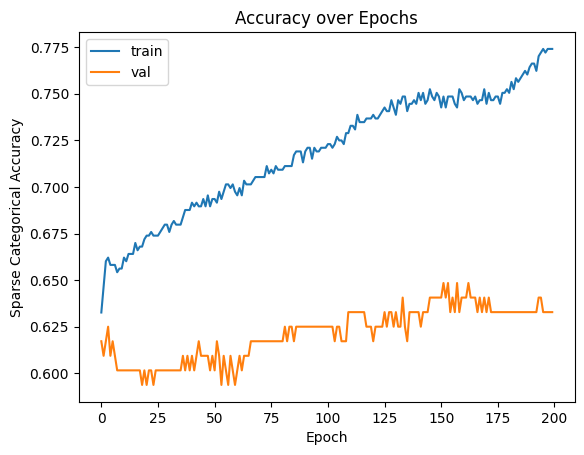

In [19]:
# Plot training & validation accuracy
# ------------------------------------
# Visualize how accuracy evolves over epochs to spot overfitting/underfitting.
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend()
plt.show()

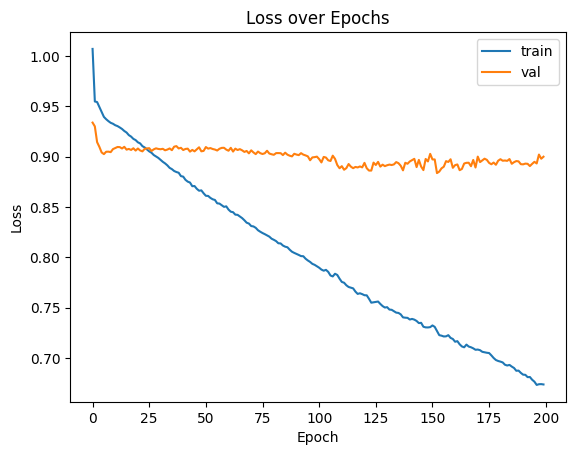

In [20]:
# Plot training & validation loss
# --------------------------------
# Show loss curves for train vs. validation to assess convergence.
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step


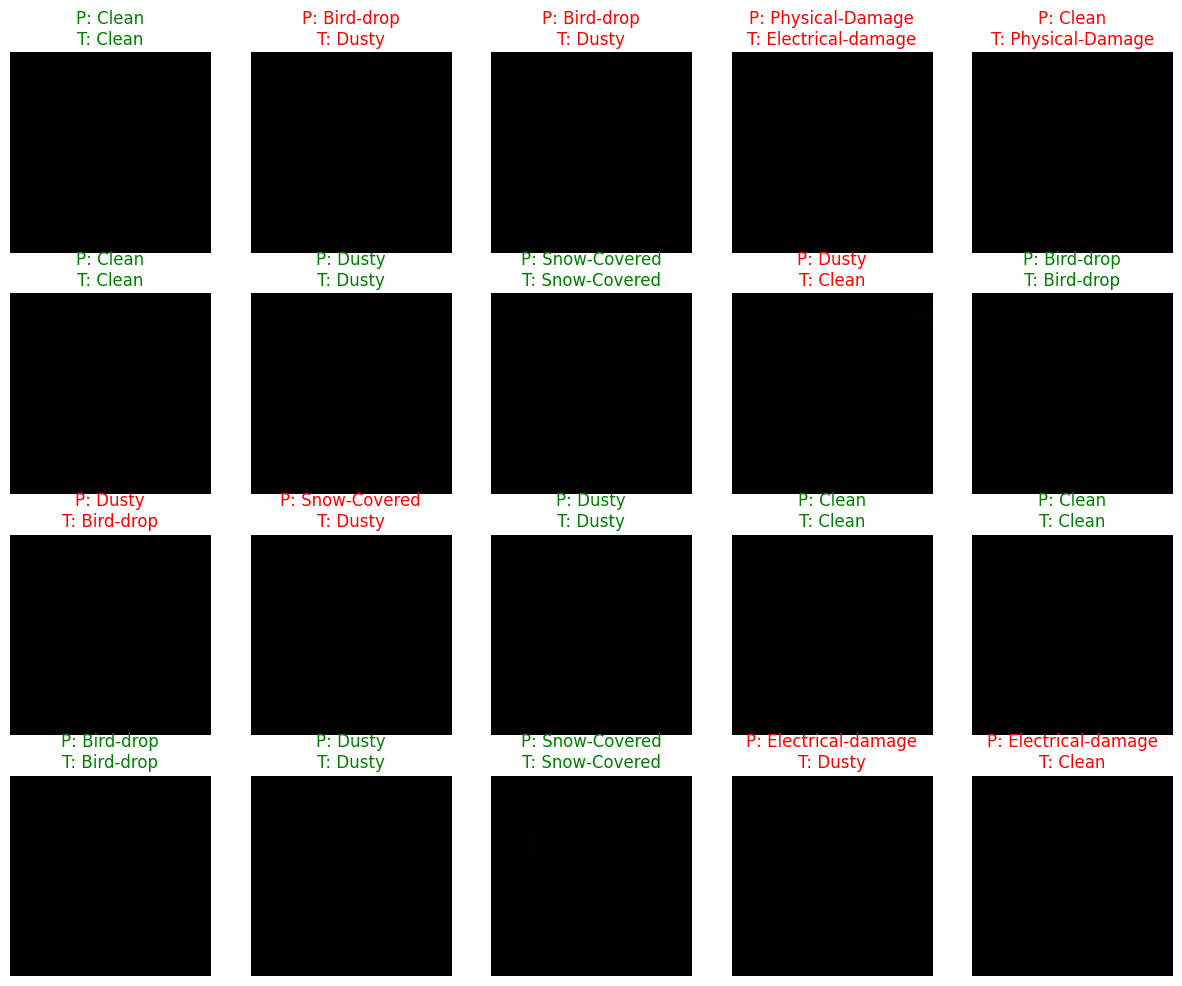

In [21]:
# Visualize sample predictions
# ----------------------------
# Take one batch from val_ds, run predictions, and display a 4×5 grid of images
# with predicted vs. true labels colored green (correct) or red (incorrect).
plt.figure(figsize=(15, 12))
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for i in range(min(20, images.shape[0])):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        color = 'green' if pred_labels[i] == labels[i] else 'red'
        plt.title(f"P: {class_names[pred_labels[i]]}\nT: {class_names[labels[i]]}", color=color)
        plt.axis('off')
plt.show()